In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.optimize as sopt
import scipy.stats as s
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

Case = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Case_Ripulite.csv')
Lavoratori = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Lavoratori_Pulito.csv')
Permessi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Permessi_Ripuliti.csv')
PIL = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/PIL_Ripuliti.csv')
Popolazione = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Popolazione_Ripulita.csv')
Tassi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Tassi_Ripuliti.csv')
#Turisti = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Turisti_ripuliti.csv')

datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi ]

for i in datasets : 
    i.TIME = pd.to_datetime(i.TIME)
    i.TIME = i.TIME.apply(lambda dt : dt.replace(day = 1))
    i.sort_values('TIME', inplace = True)
tot = Case
datasets = [ Lavoratori , Permessi , PIL , Popolazione , Tassi ]

for i in datasets : tot = tot.merge(i , on = 'TIME')

datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi]
tot.drop_duplicates(subset = 'TIME', inplace = True , ignore_index=True)
tot.drop(columns=['Year','Tipo aggregato (milioni di euro)' , 'Tipo dato' , 'Edizione_x' , 'Edizione_y' , 'Tipologia edilizia' , 'Valutazione' , 'Entity' , 'Code'] , inplace = True)
tot.rename(columns = {'Case_Nuove' : 'Permessi' , 'Population (historical estimates)' : 'Popolazione' , 'Index_Case' : 'Case'} , inplace = True )

Media = tot[tot.TIME.dt.year == 2010] 
tot.sort_values(by = 'TIME', inplace = True)
tot.Lavoratori = tot.Lavoratori/ Media.Lavoratori.mean() * 100 
tot.Permessi = tot.Permessi/ Media.Permessi.mean() * 100
tot.PIL = tot.PIL/ Media.PIL.mean() * 100 
tot.Tassi = tot.Tassi/ Media.Tassi.mean() * 100 
tot.Popolazione = tot.Popolazione/ Media.Popolazione.mean() * 100 

def traslo( Dataset) :     
    x_Dataset = pd.to_numeric(Dataset.TIME)
    y = Dataset.Permessi
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Permessi =  y - slope * x_Dataset - intercept
    
    y = Dataset.Case
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Case =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Lavoratori
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Lavoratori =  y - slope * x_Dataset - intercept 
    
    y = Dataset.PIL
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_PIL =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Popolazione
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Popolazione =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Tassi
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Tassi =  y - slope * x_Dataset - intercept 
    


    appo= {'TIME' : x_Dataset}
    appo = pd.DataFrame(Dataset)
    appo.drop(columns=['Lavoratori','Permessi','Case','Popolazione','Tassi','PIL'],inplace=True)

    appo['Case'] = Traslati_Case
    appo['Permessi'] = Traslati_Permessi
    appo['Lavoratori'] = Traslati_Lavoratori
    appo['PIL'] = Traslati_PIL
    appo['Popolazione'] = Traslati_Popolazione
    appo['Tassi'] = Traslati_Tassi
    return appo


pre = 30
post = 60

tot1 = tot[tot.TIME < tot.TIME[pre]]
tot2 = tot[tot.TIME >= tot.TIME[pre]]
tot2 = tot2[tot2.TIME < tot.TIME[post]]
tot3 = tot[tot.TIME >= tot.TIME[post]]
Pre2007 = traslo(tot1)
Post2015 = traslo(tot3)
Mezzo = traslo(tot2)
Traslato = Pre2007.merge(Mezzo , how = 'outer')
Traslato = Traslato.merge(Post2015 , how = 'outer')

In [6]:
def CrossCorrelationAnalysis(X, Y, maxlag, ax , color):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(s.pearsonr(X_lagged, Y_lagged)[0])
            
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        ax.plot(lags_min, lcc_min, lw=3, color=color)
        ax.plot(lags_maj, lcc_maj, lw=3, color='b')
        ax.vlines(0, -1, 1, lw=1, ls='--', color='k')
        ax.set_xlabel('time lags (trimester)'), ax.set_ylabel('lagged-cross-correlation')
        #ax.text(-6, 0.8, 'X preceeds house values', color=color)
        #ax.text(1, 0.8, 'house values preceeds X', color='b')
        

        return max(lagged_cross_corr)

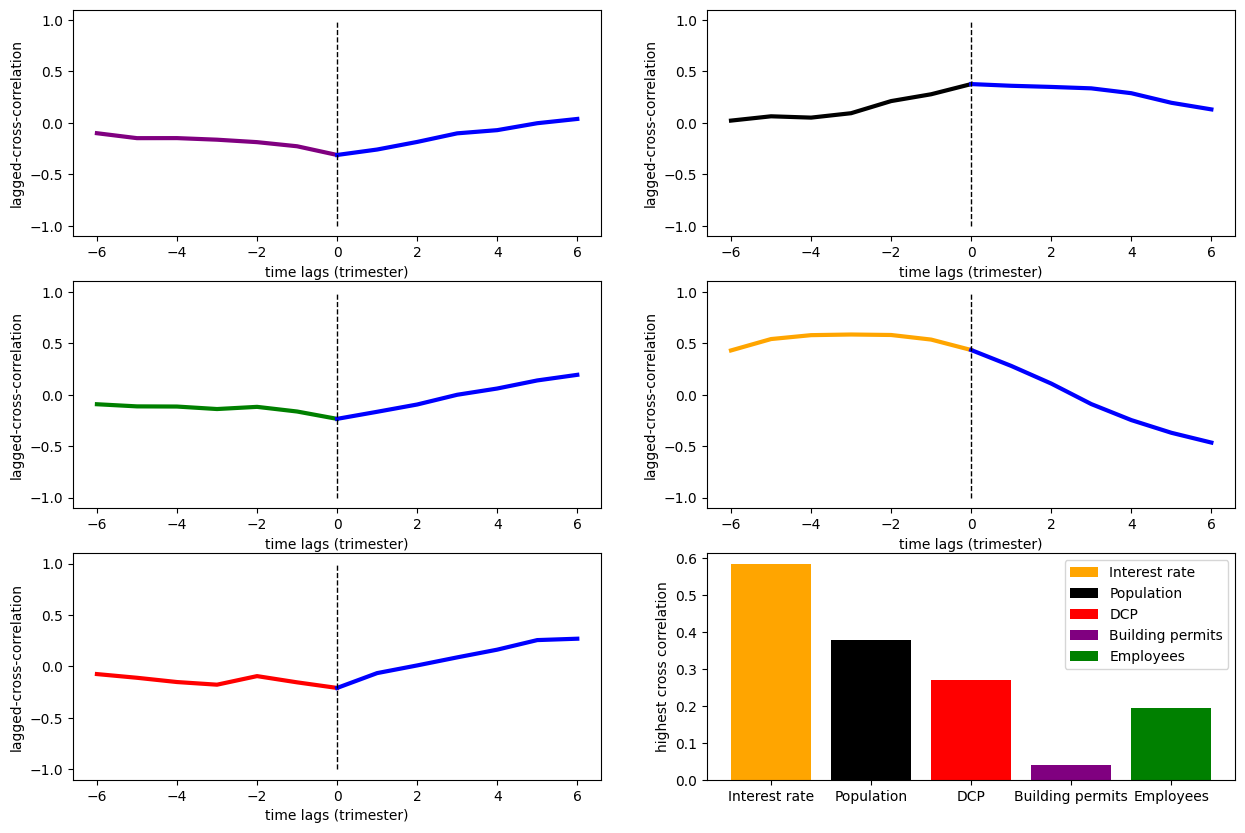

In [7]:
correletions = []
fig , axis = plt.subplots(3 , 2 , figsize=(15, 10) )
correletions.append(CrossCorrelationAnalysis(Traslato.Tassi.array, Traslato.Case.array, maxlag=6 , ax = axis[1,1] , color = 'orange'))
correletions.append(CrossCorrelationAnalysis(Traslato.Popolazione.array, Traslato.Case.array, maxlag=6 , ax = axis[0,1] , color = 'black'))
correletions.append(CrossCorrelationAnalysis(Traslato.PIL.array, Traslato.Case.array, maxlag=6 , ax = axis[2,0] , color = 'red'))
correletions.append(CrossCorrelationAnalysis(Traslato.Permessi.array, Traslato.Case.array, maxlag=6 , ax = axis[0,0] , color = 'purple'))
correletions.append(CrossCorrelationAnalysis(Traslato.Lavoratori.array, Traslato.Case.array, maxlag=6 , ax = axis[1,0] , color = 'green'))

nomi = ['Interest rate', 'Population', 'DCP', 'Building permits', 'Employees']
colori = ['orange' , 'black' , 'red' , 'purple' , 'green' ]
axis[2,1].bar(nomi, correletions, color = colori , label = nomi)
axis[2,1].set_ylabel('highest cross correlation')
axis[2,1].legend()

In [8]:
correletions

[0.5849075192745803,
 0.37771174494069254,
 0.2698225539087518,
 0.038983579599430496,
 0.1932294840931189]